In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras

In [ ]:
# Select the file and load the path
file_path = '/content/drive/MyDrive/deep_learning/project/cnn/Concrete Crack Images for Classification/data'

SEED = 345
IMG_SIZE = (160,160)
BATCH_SIZE = 50
train_dataset = tf.keras.utils.image_dataset_from_directory(
  file_path,
  validation_split=0.3,
  subset="training",
  image_size=IMG_SIZE,
  seed=SEED,
  batch_size=BATCH_SIZE)

val_dataset = tf.keras.utils.image_dataset_from_directory(
  file_path,
  validation_split=0.3,
  subset="validation",
  image_size=IMG_SIZE,
  seed=SEED,
  batch_size=BATCH_SIZE)

Found 40000 files belonging to 2 classes.
Using 28000 files for training.
Found 40000 files belonging to 2 classes.
Using 12000 files for validation.


In [ ]:
# Check class names
class_names = train_dataset.class_names
class_names

['Negative', 'Positive']

tf.Tensor(
[0 1 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 0 0 1 0 1 1 1 0 1 1 1 1 0 1 0 1 1 0
 0 1 1 1 1 1 0 1 0 0 0 0 1], shape=(50,), dtype=int32)


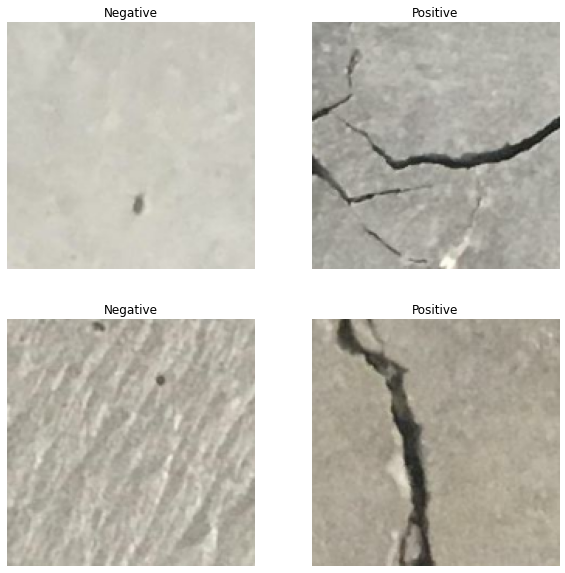

In [ ]:
# Display some images
plt.figure(figsize=(10,10))

for images, labels in train_dataset.take(1):
  # To check the labels shape
  print(labels)
  for i in range(4):
    ax = plt.subplot(2,2,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis('off')

In [ ]:
# Further split validation set, so that we obtain validation and test data
val_batches = tf.data.experimental.cardinality(val_dataset)
test_dataset = val_dataset.take(val_batches // 5) # divide by 5 to extract 20% off
validation_dataset = val_dataset.skip(val_batches // 5)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 192
Number of test batches: 48


In [ ]:
# To create prefetch dataset for better performance
AUTOTUNE = tf.data.AUTOTUNE

train_dataset_pf = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset_pf = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset_pf = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
# We will make use of the method provided in the pretrained model object to rescale input
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,include_top=False,weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
IMG_SHAPE

(160, 160, 3)

In [ ]:
# Freeze the base model and view the model structure
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [ ]:
# Create our own classification layer
class_names = train_dataset.class_names
global_avg_layer = tf.keras.layers.GlobalAveragePooling2D()
output_dense = tf.keras.layers.Dense(len(class_names),activation='softmax')

Model: "concrete_crack_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)              

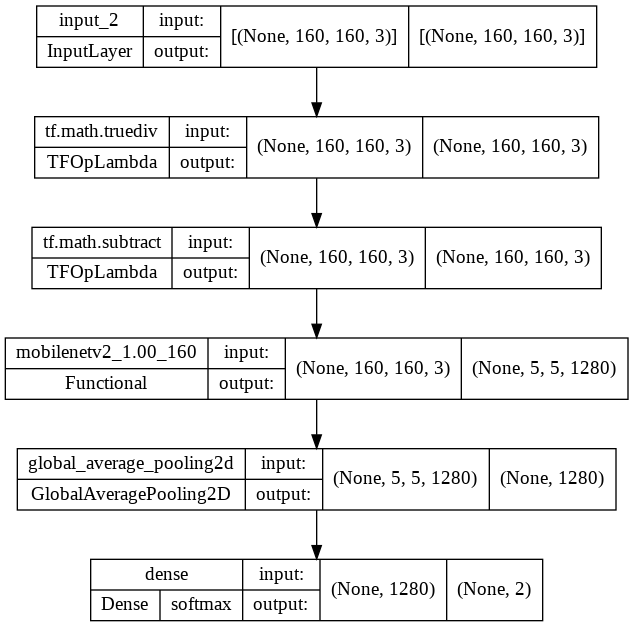

In [ ]:
# Use functional API to create the entire model (preprocess + CNN)
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = preprocess_input(inputs)
x = base_model(x,training=False)
x = global_avg_layer(x)
outputs = output_dense(x)

model = tf.keras.Model(inputs, outputs,name='concrete_crack_classification')
model.summary()
keras.utils.plot_model(model,to_file='concrete_crack_classification.png',show_shapes=True,show_layer_names=True,show_layer_activations=True)

In [ ]:
# Compile model
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

model.compile(optimizer=adam, loss=loss, metrics=['accuracy'])

In [ ]:
EPOCHS = 5
history = model.fit(train_dataset_pf,validation_data=validation_dataset_pf,epochs=EPOCHS)

Epoch 1/5
560/560 [==============================] - 2645s 4s/step - loss: 0.1035 - accuracy: 0.9693 - val_loss: 0.0225 - val_accuracy: 0.9964
Epoch 2/5
560/560 [==============================] - 105s 185ms/step - loss: 0.0156 - accuracy: 0.9970 - val_loss: 0.0132 - val_accuracy: 0.9969
Epoch 3/5
560/560 [==============================] - 108s 192ms/step - loss: 0.0103 - accuracy: 0.9978 - val_loss: 0.0097 - val_accuracy: 0.9979
Epoch 4/5
560/560 [==============================] - 107s 190ms/step - loss: 0.0081 - accuracy: 0.9981 - val_loss: 0.0084 - val_accuracy: 0.9978
Epoch 5/5
560/560 [==============================] - 105s 186ms/step - loss: 0.0068 - accuracy: 0.9982 - val_loss: 0.0079 - val_accuracy: 0.9978


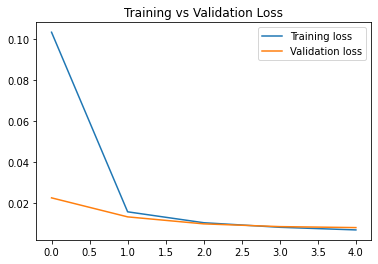

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plot training vs validation loss
training_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = history.epoch

plt.plot(epochs,training_loss,label='Training loss',)
plt.plot(epochs,val_loss,label='Validation loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.figure()
plt.show()

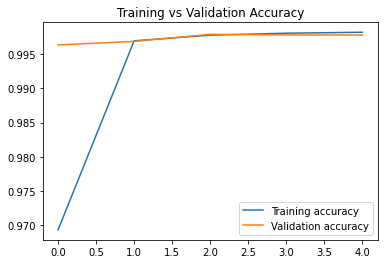

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plot training vs validation accuracy
training_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = history.epoch

plt.plot(epochs,training_accuracy,label='Training accuracy')
plt.plot(epochs,val_accuracy,label='Validation accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.figure()
plt.show()

In [ ]:
# Evaluate with test dataset
test_loss,test_accuracy = model.evaluate(test_dataset_pf)

print('------------------------Test Result----------------------------')
print(f'Loss = {test_loss}')
print(f'Accuracy = {test_accuracy}')

48/48 [==============================] - 8s 138ms/step - loss: 0.0060 - accuracy: 0.9992
------------------------Test Result----------------------------
Loss = 0.005987724754959345
Accuracy = 0.9991666674613953
